##Machine Learning - UT - Spring 2024
##HW 3 - Q4
##Ali Khoramfar - 810102129

###Import Packages

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


### Simple MultiClass Boosting

In [ ]:

class SimpleMultiClassBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=50):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.learners = []
        self.learner_weights = []
        self.label_encoder = LabelEncoder()

    def fit(self, X, y):
        # Convert labels to [0, n_classes-1]
        y = self.label_encoder.fit_transform(y)
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Initialize weights uniformly
        sample_weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            learner = clone(self.base_estimator)
            learner.fit(X, y, sample_weight=sample_weights)
            y_pred = learner.predict(X)

            # Compute weighted error rate (misclassification rate)
            incorrect = (y_pred != y)
            learner_error = np.dot(sample_weights, incorrect) / np.sum(sample_weights)

            # Compute learner weight
            learner_weight = np.log((1 - learner_error) / (learner_error + 1e-10)) + np.log(n_classes - 1)

            if learner_error >= 0.5:
                break  # Stop if the learner is worse than random guessing

            # Increase the weights of misclassified samples
            sample_weights[incorrect] *= np.exp(learner_weight)
            sample_weights /= np.sum(sample_weights)  # Normalize

            # Save the current learner
            self.learners.append(learner)
            self.learner_weights.append(learner_weight)

    def predict(self, X):
        # Collect predictions from each learner
        learner_preds = np.array([learner.predict(X) for learner in self.learners])

        # Weighted vote for each sample's prediction across all learners
        weighted_votes = np.zeros((X.shape[0], len(self.label_encoder.classes_)))
        for i in range(len(self.learners)):
            for j in range(X.shape[0]):
                weighted_votes[j, learner_preds[i, j]] += self.learner_weights[i]

        # Final prediction is the one with the highest weighted vote
        final_preds = np.argmax(weighted_votes, axis=1)

        # Convert back to original class labels
        return self.label_encoder.inverse_transform(final_preds)

### Load Dataset

In [ ]:
data = load_iris()
X = data.data
y = data.target

# 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

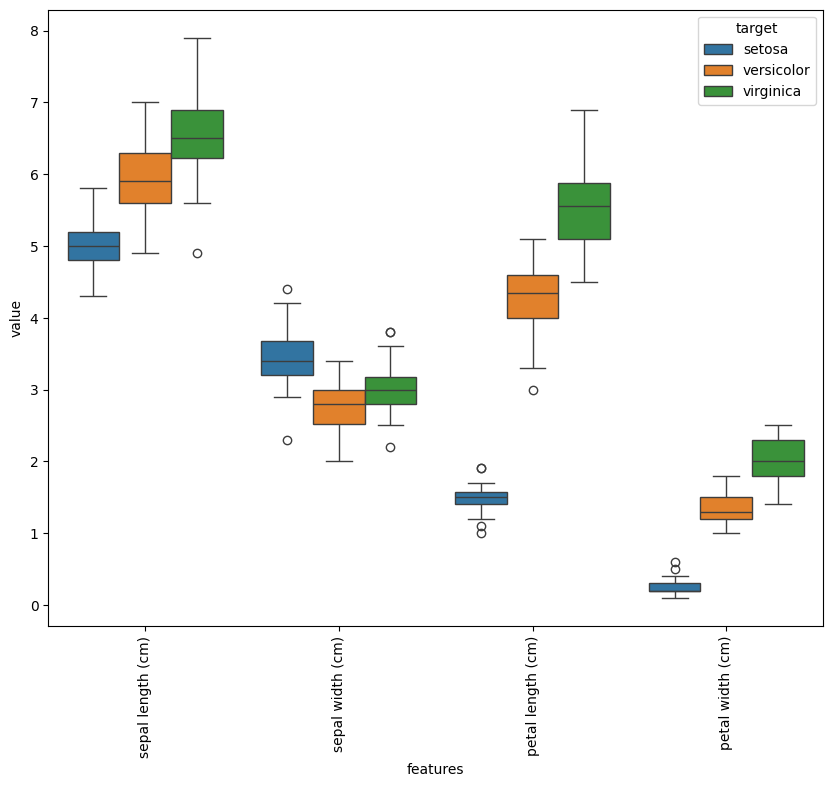

In [ ]:
feature_names = data.feature_names
target_names = data.target_names
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['target'] = df['target'].apply(lambda x: target_names[x])

df_melted = df.melt(id_vars='target', var_name='features', value_name='value')
plt.figure(figsize=(10, 8))
sns.boxplot(x='features', y='value', hue='target', data=df_melted)
plt.xticks(rotation=90)
plt.show()

##Train Model

In [ ]:
base_classifier = DecisionTreeClassifier(max_depth=1)
boosting_model = SimpleMultiClassBoosting(base_estimator = base_classifier , n_estimators=50)
boosting_model.fit(X_train, y_train)

##Classification Report

In [ ]:
y_pred = boosting_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm= confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)

Accuracy: 1.0
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


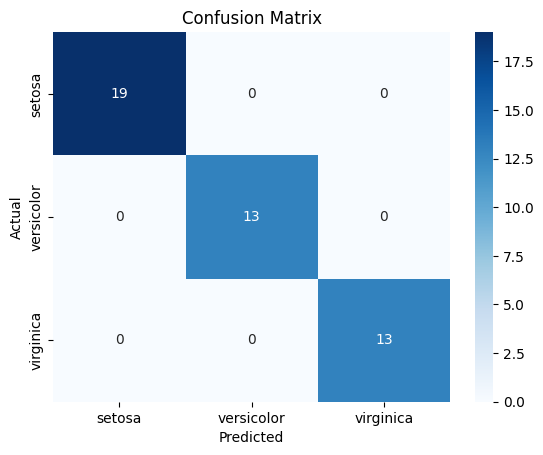

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()